### Downloaded subtitle files from OpenSubtitles

## Data Aquisition

Downloaded all data from [OpenSubtitles](https://www.opensubtitles.org/en/ssearch/sublanguageid-all/idmovie-484229`).

Unfortunately, there were a few episodes missing, and they were episodes I'm interested in. I retrieved these episodes from [CNN](http://www.cnn.com/TRANSCRIPTS/abpu.html). I considered using the CNN transcripts for the full project, but that data set was also incomplete and had more formatting issues than the open subtitles transcripts.

My initial processing of transcripts from the two sources was tailored to the unique structure of the two transcript file types. For the OpenSubtitle files I processed with a modified script [here](https://gist.github.com/ndunn219/62263ce1fb59fda08656be7369ce329b) (modifications saved as the subtitle_lib module in this repo) and filtered the text to remove the intro theme song. For the CNN files, I used regex to remove narration indicators and a few common transcript words that appeared in this format.

After initial processing, both file types were combined into a pandas data frame containing episode information and the full transcript text.

In [75]:
import nltk
import os, os.path
import pandas as pd
import glob
import re
import numpy as np

# import python module to clean transcripts
from subtitle_lib.srt_formatting import *

In [76]:
# make list of full directory path names for each season

path = os.getcwd() + '/puk_data/'
dirs = os.listdir(path)
dirs.remove('.DS_Store')

full_dirs = []
for file in dirs:
    full_dir = path + file
    full_dirs.append(full_dir)

In [ ]:
# make list of full episode path names for each episode of each season

episode_files = []
for file in full_dirs:
    contents = (glob.glob('{}/*'.format(file)))
    for episode in contents[:(len(contents))]:
        episode_srt = (glob.glob('{}/*'.format(episode)))
        episode_files.append(episode_srt[0])

In [5]:
# function to call cleaning scripts (from subtitle_lib.srt module) and write cleaned file as txt

def clean_save_file(file_name):
    with open(file_name, encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
        new_file_name = 'processed_text/' + file_name[-28:-22] + '.txt'
        #print(new_file_name)
        with open(new_file_name, 'w') as f:
            for line in new_lines:
                f.write(line)

In [6]:
# call cleaning function on each episode, save to file

for episode in episode_files:
    clean_save_file(episode)

In [7]:
# cleaning function for transcripts from CNN (not open subtitles)

def clean_save_CNN_file(file_name):
    with open(file_name, encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
        new_lines = clean_up(lines)
        new_file_name = 'processed_text/' + file_name[-10:]
        #print(new_file_name)
        with open(new_file_name, 'w') as f:
            for line in new_lines:
                f.write(line)

In [8]:
# make full file name of new episodes

CNN_episode_paths = []
for item in os.listdir(os.getcwd() + '/puk_data/cnn_transcripts/'):
    CNN_episode_paths.append('/Users/jeff/Desktop/K2_DataScience/K2_NLP_project/puk_data/cnn_transcripts/' +item)

# call CNN cleaning function for new episodes

for episode in CNN_episode_paths:
    clean_save_CNN_file(episode)

### Filtering Episode Text and Saving to DF

In [9]:
# make list of full directory path names for each season

path = os.getcwd() + '/processed_text/'
files = os.listdir(path)
files.remove('.DS_Store') 
files.remove( '.480p..txt') # not sure what this file is, doesn't appear in file browser, removed
files.remove( '.S06E0.txt') # ditto

full_file_paths = [path + f for f in files] # create full file paths

In [10]:
# get subtitle text from each episode file

episode_list = [] # append tuple of episodeID and subtitle text to list

for f in full_file_paths:
    file = open(f, 'rU')
    episode_text = file.read()
    episode_name = (re.search(r'[ \w-]+?(?=\.)',f))[0]
    episode_info = (episode_name, episode_text)
    episode_list.append(episode_info)

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 'U' mode is deprecated


In [11]:
# get CNN text from each CNN episode file

CNN_episode_list = [] # append tuple of episodeID and subtitle text to list

for f in CNN_episode_paths:
    file = open(f, 'rU')
    episode_text = file.read()
    episode_name = (re.search(r'[ \w-]+?(?=\.)',f))[0]
    episode_info = (episode_name, episode_text)
    CNN_episode_list.append(episode_info)

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 'U' mode is deprecated


In [12]:
complete_episodes = episode_list + CNN_episode_list

In [13]:
# append episodeID and subtitle text data to df
puk = pd.DataFrame.from_records(complete_episodes)
puk.columns=['episodeID', 'text']

In [14]:
# read in csv with episode location information
episode_locations = pd.DataFrame.from_csv('puk_episode_list.csv',  index_col=None)

In [15]:
# merge location names into reviews df
puk = puk.merge(episode_locations, on='episodeID', how='left')

In [16]:
# convert str dates into date time objects 
puk.air_date = pd.to_datetime(puk.air_date)

In [17]:
puk.head()

,episodeID,text,season,episode,air_date,episode_location,j_j
0,S05E02,Miami sneaks up on you.\nOr do we change and f...,5,2,2015-05-03,Miami,N
1,S09E02,♪ I took a walk through this ♪\n♪ Beautiful wo...,9,2,2017-05-07,San Sebastian,N
2,S07E07,"ANTHONY BOURDAIN, CNN HOST: They say, and by ""...",7,7,2016-06-05,"Cologne, Germany",Y
3,S07E06,BOURDAIN: At first you see what you see in so ...,7,6,2016-05-29,Senegal,N
4,S09E03,"In the early 1960s, three idealistic young CIA...",9,3,2017-05-14,Laos,Y


In [18]:
# remove narration assignment from CNN transcripts and several common 'transcript' words

CNN_episodes = [x[:-4] for x in list(os.listdir(os.getcwd() + '/puk_data/cnn_transcripts/'))]

for episode in CNN_episodes:
    text = (puk.text[puk.episodeID==episode]).values[0]
    name_pattern = r'\b[A-Z0-9]{2,}\b'
    common_words = r'\W*(translator|voice-over|on camera|inaudible)\W*'
    first_search = re.sub(name_pattern,'',text)
    cleaned_text = re.sub(common_words,' ',first_search)
    puk.text[puk.episodeID==episode] = cleaned_text

/Users/jeff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
# funct to remove line containing a certain character

def remove_line(text, char):
    parsed_lines = []
    lines_tokens = nltk.sent_tokenize(text)
    for line in lines_tokens:
        if char not in line:
            keep_line = line
            parsed_lines.append(keep_line)
    text_str = '\n'.join(parsed_lines)
    return text_str

In [20]:
# remove theme song from subtitle text using the '♪' character

parsed_text = []

for idx,episode in puk.iterrows():
    text = episode.text
    text = remove_line(text, '♪')
    parsed_text.append(text)

puk['clean_text'] = parsed_text

In [21]:
# print a sample review
sample_review_full = puk.iloc[55]
sample_review = sample_review_full.clean_text[0:102]

In [22]:
sample_review_full

episodeID                                                      S08E03
text                You know what I like?\nI like Sichuan.\nMan, I...
season                                                              8
episode                                                             3
air_date                                          2016-10-16 00:00:00
episode_location                             Sichuan with Eric Ripert
j_j                                                                 N
clean_text          You know what I like?\nI like Sichuan.\nMan, I...
Name: 55, dtype: object

In [23]:
sample_review

'You know what I like?\nI like Sichuan.\nMan, I love the food here.\nYou know what else I like?\nTorturing '

## Define punctuation and tokenize the text

In [24]:
import re
import string

# string.punctuation is simply a string of all special characters
translator = str.maketrans(string.punctuation, ' '*32)
print('All english punctuation strings: %s' % string.punctuation)

All english punctuation strings: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [25]:
# Testing tokenization on sample review
print(sample_review,'\n')

# tokenize and print tokens from the sample review
sample_tokens = nltk.word_tokenize(sample_review)
print(sample_review,'\n')

# Highlight Punctuations using regex to detect punctuation chars in the text
punkt_pattern = re.compile('['+string.punctuation+']')  # create regex pattern obj

# print a set of detected punctuation chars
sample_punkt = [p.group(0) for token in sample_tokens for p in [punkt_pattern.search(token)] if p]
print("Punctuation in review: %s" % set(sample_punkt))

You know what I like?
I like Sichuan.
Man, I love the food here.
You know what else I like?
Torturing  

You know what I like?
I like Sichuan.
Man, I love the food here.
You know what else I like?
Torturing  

Punctuation in review: {',', '?', '.'}


In [26]:
#Various Tokenizers
from nltk.tokenize import TreebankWordTokenizer, WordPunctTokenizer, WhitespaceTokenizer

sample_text = sample_review

sample_treebank_ = TreebankWordTokenizer().tokenize(sample_text)
sample_wordpunct_ = WordPunctTokenizer().tokenize(sample_text)
sample_wspace_ = WhitespaceTokenizer().tokenize(sample_text)
# NLTK Recommended: word_tokenize == Treebank for most cases
sample_word_ = nltk.word_tokenize(sample_text)

print(sample_treebank_)
print('Treebank Tokenizer found %d tokens\n' % len(sample_treebank_))

print(sample_wordpunct_)
print('WordPunct Tokenizer found %d tokens\n' % len(sample_wordpunct_))

print(sample_wspace_)
print('Whitespace Tokenizer found %d tokens\n' % len(sample_wspace_))

print(sample_word_)
print('nltk.word_tokenize Tokenizer found %d tokens\n' % len(sample_word_))

['You', 'know', 'what', 'I', 'like', '?', 'I', 'like', 'Sichuan.', 'Man', ',', 'I', 'love', 'the', 'food', 'here.', 'You', 'know', 'what', 'else', 'I', 'like', '?', 'Torturing']
Treebank Tokenizer found 24 tokens

['You', 'know', 'what', 'I', 'like', '?', 'I', 'like', 'Sichuan', '.', 'Man', ',', 'I', 'love', 'the', 'food', 'here', '.', 'You', 'know', 'what', 'else', 'I', 'like', '?', 'Torturing']
WordPunct Tokenizer found 26 tokens

['You', 'know', 'what', 'I', 'like?', 'I', 'like', 'Sichuan.', 'Man,', 'I', 'love', 'the', 'food', 'here.', 'You', 'know', 'what', 'else', 'I', 'like?', 'Torturing']
Whitespace Tokenizer found 21 tokens

['You', 'know', 'what', 'I', 'like', '?', 'I', 'like', 'Sichuan', '.', 'Man', ',', 'I', 'love', 'the', 'food', 'here', '.', 'You', 'know', 'what', 'else', 'I', 'like', '?', 'Torturing']
nltk.word_tokenize Tokenizer found 26 tokens



In [27]:
from nltk.stem.porter import PorterStemmer
from numba import jit
st = PorterStemmer()

@jit
def stemmer():
    r_vocab = {}
    global_vocab = {}

    for idx, episode in puk.iterrows():
        for token in nltk.word_tokenize(episode.clean_text.translate(translator)):
            stemmed_token = st.stem(token.lower())
            if stemmed_token in global_vocab:
                global_vocab[stemmed_token].append(episode.episodeID)
            else:
                global_vocab[stemmed_token] = [episode.episodeID]
            if episode.episodeID in r_vocab:
                r_vocab[episode.episodeID].append(stemmed_token)
            else:
                r_vocab[episode.episodeID] = [stemmed_token]
    return r_vocab, global_vocab

In [28]:
r_vocab, global_vocab = stemmer()

In [29]:
# create list of words with and without stop words

from nltk.corpus import stopwords

all_vocab = list(global_vocab.keys())

non_stopword_vocab = [w for w in all_vocab if w not in list(stopwords.words('english'))]

print(len(all_vocab), len(non_stopword_vocab))

14065 13941


In [84]:
# create a dict with every word as keys and their counts as values
def wordCount(vocabulary):
    wordCounts = {}
    for word in vocabulary:
        wordCounts[word] = len(vocabulary[word])
    return wordCounts

In [85]:
# made dict of only non-stopwords
non_stopword_dict = {}

for word in non_stopword_vocab:
    non_stopword_dict[word] = global_vocab[word]

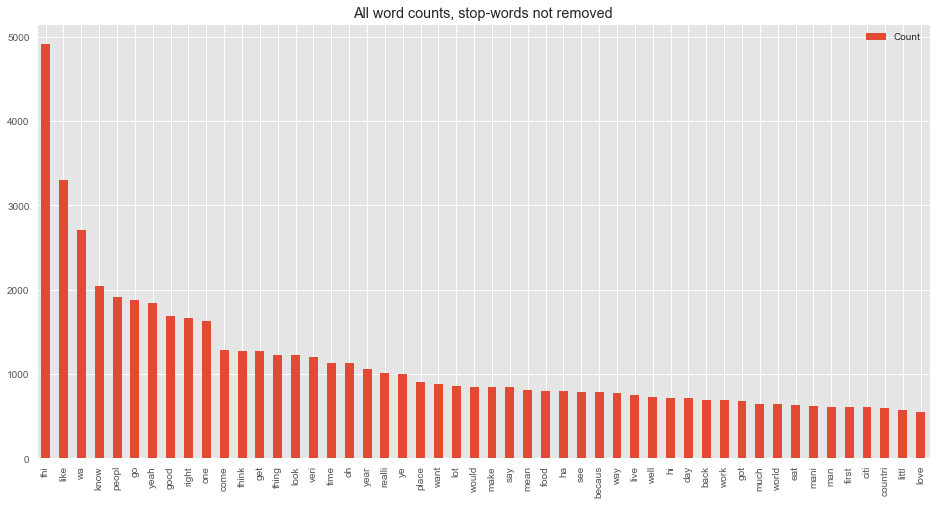

In [86]:
# let's plot some wordcounts
all_wordsCounts = wordCount(global_vocab)
all_wordsCounts_DF = pd.DataFrame.from_dict(all_wordsCounts, orient='index')
all_wordsCounts_DF.columns = ['Count']
all_wordsCounts_DF = all_wordsCounts_DF.sort_values('Count', ascending=False)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, ax = plt.subplots(1, 1, figsize=(16,8))
wordCounts_DF[0:50].plot.bar(ax=ax)
plt.title('All word counts, stop-words not removed')

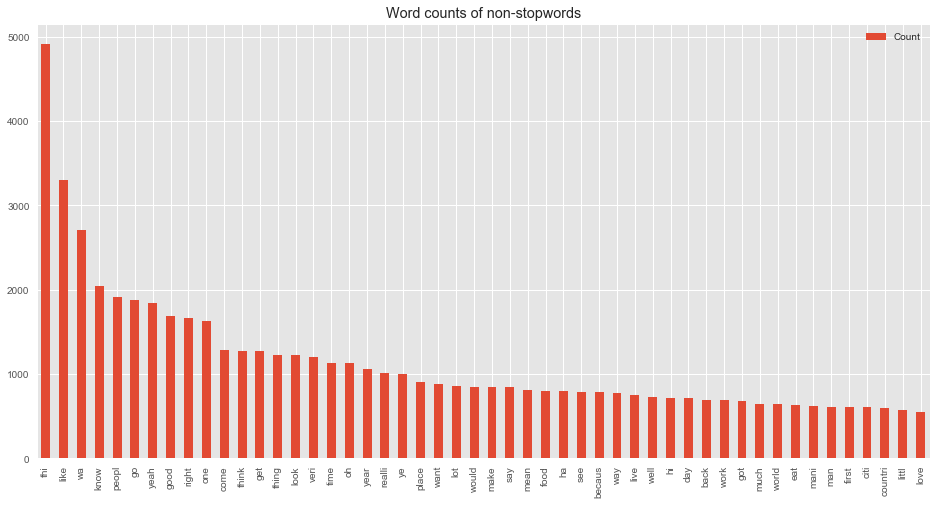

In [87]:
# let's plot some wordcounts
wordCounts = wordCount(non_stopword_dict)
wordCounts_DF = pd.DataFrame.from_dict(wordCounts, orient='index')
wordCounts_DF.columns = ['Count']
wordCounts_DF = wordCounts_DF.sort_values('Count', ascending=False)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, ax = plt.subplots(1, 1, figsize=(16,8))
wordCounts_DF[0:50].plot.bar(ax=ax)
plt.title('Word counts of non-stopwords')

In [88]:
print(all_wordsCounts_DF.head(n=20))
print(wordCounts_DF.head(n=20))

      Count
the   18889
a     11194
and   10743
of     9784
to     9324
it     9228
i      9220
you    9161
s      8449
in     7077
is     6718
that   6425
thi    4912
we     3626
like   3297
for    3289
they   3252
here   2827
wa     2704
what   2702
        Count
thi      4912
like     3297
wa       2704
know     2040
peopl    1912
go       1884
yeah     1846
good     1692
right    1665
one      1626
come     1280
think    1272
get      1270
thing    1232
look     1227
veri     1202
time     1131
oh       1129
year     1062
realli   1014


### TF-IDF

In [90]:
# create a dict of tf-idf for a sample review

test_tfidf = {}

# compute tf-idf and update dict
for token in r_vocab['S03E05']:
    if not token in test_tfidf:
        tf = np.log(1.*r_vocab['S03E05'].count(token)) + 1.
        idf = np.log(1. + len(puk)*1. / len(set(global_vocab[token])) )
        test_tfidf[token] = tf * idf
    
# sort the results decending by value
sorted_tfidf = sorted(test_tfidf.items(), key=lambda x: -x[1])

# print out results
for (k, v) in sorted_tfidf:
    print("%s : %f" % (k, v))

putin : 14.751331
russia : 11.327807
sochi : 10.916607
luna : 10.916607
mtv : 10.916607
blini : 9.600545
petersburg : 9.600545
moscow : 9.482519
gentl : 9.287029
russian : 8.988939
zamir : 8.167422
vladimir : 8.167422
alexand : 8.167422
trickl : 8.167422
propaganda : 8.167422
gay : 7.921019
olymp : 7.843142
birch : 7.745659
kgb : 7.745659
explet : 7.745659
yoy : 7.745659
polonium : 7.745659
levedev : 7.745659
bentley : 7.745659
lesbian : 7.745659
sergei : 7.745659
czar : 7.745659
uri : 7.745659
ukrain : 7.745659
billionair : 6.755172
accus : 6.755172
palac : 6.590937
maximum : 6.589425
oligarch : 6.589425
radioact : 6.589425
conspiraci : 6.589425
26 : 6.589425
cedar : 6.589425
hooligan : 6.589425
skinhead : 6.589425
soviet : 6.120724
dose : 5.920102
repercuss : 5.920102
caviar : 5.862495
critic : 5.732476
imperi : 5.642788
billion : 5.544513
ralli : 5.450031
journal : 5.450031
activist : 5.428661
seri : 5.288080
2001 : 5.089063
vodka : 5.089063
allegedli : 5.089063
salmon : 5.089063
co

easili : 2.061423
defend : 2.061423
complain : 2.061423
next : 2.060547
by : 2.059199
re : 2.059199
chef : 2.049315
buy : 2.042628
wouldn : 2.042628
off : 2.039799
person : 2.027024
everyth : 2.022482
put : 2.005471
yorker : 2.001480
arrest : 2.001480
unfortun : 2.001480
winter : 2.001480
associ : 2.001480
buri : 2.001480
risk : 2.001480
avoid : 2.001480
toler : 2.001480
sex : 2.001480
genuin : 2.001480
nowher : 2.001480
object : 2.001480
came : 1.988757
yeah : 1.988757
down : 1.988757
son : 1.986525
bread : 1.986525
into : 1.972333
even : 1.972333
still : 1.972333
guy : 1.972333
today : 1.966725
matter : 1.959738
rock : 1.959738
roll : 1.959738
could : 1.956190
fascin : 1.945910
decis : 1.945910
frankli : 1.945910
prime : 1.945910
sour : 1.945910
obviou : 1.945910
report : 1.945910
shut : 1.945910
crisi : 1.945910
victim : 1.945910
lemon : 1.945910
escap : 1.945910
maker : 1.945910
vote : 1.945910
endur : 1.945910
democrat : 1.945910
fail : 1.945910
gold : 1.945910
american : 1.942831

In [91]:
# create a dataframe to be used in plotting
test_tfidf_DF = pd.DataFrame.from_dict(test_tfidf, orient='index')
test_tfidf_DF.columns = ['TF-IDF']
test_tfidf_DF = test_tfidf_DF.sort_values('TF-IDF', ascending=False)
test_tfidf_DF.head()

,TF-IDF
putin,14.751331
russia,11.327807
mtv,10.916607
luna,10.916607
sochi,10.916607


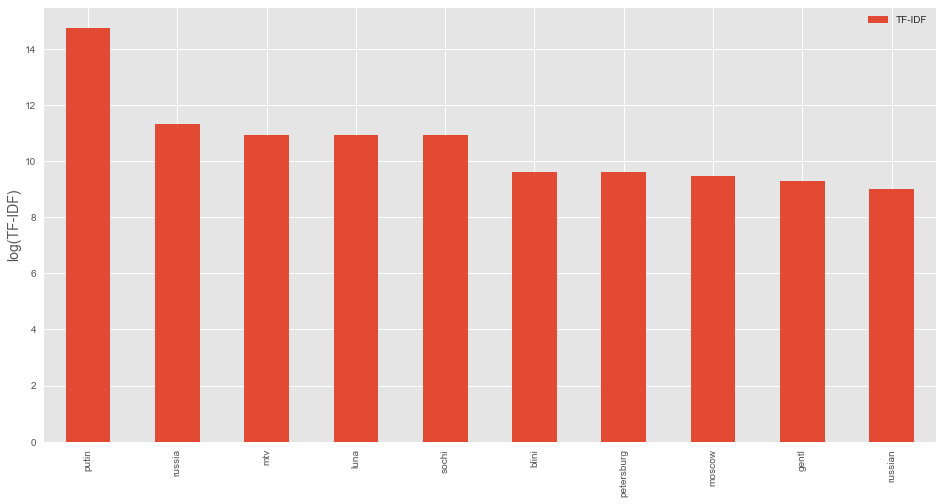

In [92]:
# plot the sample tf-idf results
fig, ax = plt.subplots(1, 1, figsize=(16,8))
test_testidf_DF = test_tfidf_DF.head(n=10)
test_testidf_DF.plot.bar(ax=ax)
plt.ylabel('log(TF-IDF)', size=14)

### Build a sparse feature matrix

In [93]:
# first define a stemmer and tokenizer that removes punctuation

porterStemmer = PorterStemmer()

# get list of lemmatized/stemmed tokens
def stemTokenList(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]
    
# get out stemmed tokens from text and remove punctuation

def noPunctWordTokenizerStemmer(text, stemmer=porterStemmer):
    # basic tokens to feed to our stem tokenizer
    tokens = nltk.word_tokenize(text.translate(translator))
    # stem
    stemmed_tokens = stemTokenList(tokens, stemmer)
    return stemmed_tokens

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert a collection of text documents to a matrix of token counts
# we get to pass our custom tokenizer
counter = CountVectorizer(stop_words='english', tokenizer=noPunctWordTokenizerStemmer)
# create the sparse matrix using counter on reviews
features_counts = counter.fit_transform(puk['clean_text'].values)

print("Count matrix of %d reviews with %d feature tokens" % features_counts.shape)

Count matrix of 96 reviews with 13857 feature tokens


Next we use TfidfTransformer to transform our sparse count matrix to a normalizedtf-idf representation:

In [95]:
from sklearn.feature_extraction.text import TfidfTransformer

# create the transformer
# use_id=True tells it to return tf-idf instead of just tf
tfidf = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=True)
# get the transformation of our counts matrix
features_tfidf = tfidf.fit_transform(features_counts)

print("TF-IDF matrix of %d reviews with %d feature tokens" % features_tfidf.shape)

TF-IDF matrix of 96 reviews with 13857 feature tokens


In [96]:
counts_names = [counter.get_feature_names()[idx] for idx in features_counts[8,:].indices]
counts_values = features_counts[8,:].data

for i in range(len(counts_values)):
    print(counts_names[i], ':', counts_values[i])

shine : 1
poison : 1
immun : 1
inhabit : 1
site : 1
sacr : 1
prosciutto : 2
blind : 2
damascu : 1
heret : 1
persecut : 1
behead : 2
lop : 1
upsid : 1
crucifi : 1
antonio : 3
fiesta : 1
pietro : 1
paolo : 1
doubl : 1
santi : 1
di : 1
festa : 2
nazi : 1
brava : 1
signor : 1
mi : 1
scusi : 1
puglies : 1
priest : 1
buonissimo : 1
smoki : 1
caciocavallo : 1
cacio : 1
cacioricotta : 1
ricotta : 1
nonna : 1
angelo : 1
sera : 1
buona : 1
lookout : 1
eccellent : 1
bellissima : 3
disgust : 1
airbnb : 2
postcard : 1
hipster : 1
expens : 2
incorpor : 1
christ : 4
gibson : 1
mel : 1
reloc : 1
forcibl : 1
prevent : 1
quinin : 1
beg : 1
endem : 1
malaria : 1
mortal : 1
loser : 1
bandit : 1
condit : 1
dysfunct : 1
empir : 1
span : 1
occupi : 1
matera : 3
cave : 6
gunman : 1
lone : 1
remind : 1
hysteria : 1
spasm : 1
swell : 1
pizzica : 1
evolv : 1
ritualist : 1
ultim : 1
releas : 1
orgasm : 1
ecstat : 1
remedi : 1
tongu : 1
sudden : 2
tarantella : 2
toxic : 1
supernatur : 1
tortur : 3
carnal : 1
distu

In [97]:
# extract the feature names
feature_names = [counter.get_feature_names()[idx] for idx in features_tfidf[30,:].indices]
# extract the tf-idf values for the features
feature_values = features_tfidf[30,:].data

# sort them descending by score
test_features = sorted(list(zip(feature_names, feature_values)), key=lambda x: -x[1])

for item in test_features:
    print(item)

('newfoundland', 0.15501335178361697)
('moos', 0.12131120199370275)
('scrunchion', 0.10932672887113269)
('codfish', 0.10360598766516624)
('paté', 0.096839786933155661)
('cod', 0.091112795346256131)
('moratorium', 0.088558626510902669)
('fisheri', 0.083089229108423021)
('bladder', 0.083089229108423021)
('fred', 0.08182773147367281)
('trawler', 0.077882353866909379)
('manson', 0.077882353866909379)
('beausoleil', 0.077882353866909379)
('tureen', 0.077882353866909379)
('jigg', 0.077882353866909379)
('ax', 0.077882353866909379)
('canada', 0.077217022590765197)
('jeremi', 0.075983934297281674)
('charl', 0.071935787589155725)
('urchin', 0.069447383700234427)
('scallop', 0.067002107725490118)
('chanterel', 0.066823616086822774)
('axe', 0.066823616086822774)
('whelk', 0.066823616086822774)
('canadian', 0.065831694645255345)
('jig', 0.062834992712645796)
('labrador', 0.062834992712645796)
('beau', 0.062834992712645796)
('soleil', 0.062834992712645796)
('hogzilla', 0.062834992712645796)
('sac', 

('state', 0.0097633302998550876)
('goe', 0.0097633302998550876)
('hous', 0.0096598953643290963)
('outsid', 0.0096598953643290963)
('doesn', 0.0096598953643290963)
('ask', 0.0095578488591761598)
('commun', 0.0095578488591761598)
('stori', 0.0094571540031487614)
('understand', 0.0094571540031487614)
('sauc', 0.0094571540031487614)
('busi', 0.0093577754574850607)
('known', 0.0093577754574850607)
('turn', 0.0091628327126355921)
('leav', 0.0091628327126355921)
('point', 0.0091628327126355921)
('anyth', 0.0090672044016051421)
('sinc', 0.0089727640506500148)
('hour', 0.0089727640506500148)
('sort', 0.008787331675124058)
('sure', 0.008606314778442448)
('ani', 0.0081717764831762546)
('home', 0.0079224967576842099)
('everybodi', 0.0077607385172461128)
('old', 0.0076811320256052361)


In [98]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=12, learning_method='batch')
lda.fit(features_counts)

/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=12, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
plt.plot(sorted(lda.components_[0], key= lambda x: -x)[0:1000])
plt.yscale('log')

In [ ]:
# The Topics-by-Document Matrix
docTopics = lda.transform(features_counts)
print(docTopics.shape)

In [ ]:
lda.components_[0]

In [ ]:
# Order and select the top words per topic from a LDA term-by-topic matrix
def topicsToDict(components, names, n_tokens=20):
    topicsDict = {}
    for topic_id, topic in enumerate(components):
        topicsDict[str(topic_id)] = [names[i] for i in topic.argsort()[:-n_tokens-1:-1]]
    return topicsDict

## Now I'm using the functions defined in the reference below

In [ ]:
use this reference!!!
https://nlpforhackers.io/recipe-text-clustering/

In [41]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 15
n_top_words = 8


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
#dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                             remove=('headers', 'footers', 'quotes'))
data_samples = list(puk.clean_text)
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)

print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 0.000s.
Extracting tf-idf features for NMF...
done in 0.537s.
Extracting tf features for LDA...
done in 0.521s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.090s.

Topics in NMF model (Frobenius norm):
Topic #0: yeah country eat city great fish beautiful came
Topic #1: tokyo sushi manga japanese japan karate sex different
Topic #2: yeah gonna uh okay mmm hmm cheese whoa
Topic #3: brazil african detroit ph oil yeah beach music
Topic #4: marseille france pizza fishing city eric interesting fish
Topic #5: senegal senegalese dakar uh africa colonial african race
Topic #6: cologne turkish carnival german germany ugly beer ph
Topic #7: georgia cha russia putin toast soviet hangover russian
Topic #8: greek greece islands crisis island tourism wine basically
Topic #9: cuba ph money hip revolution rum hop access
Topic #10: mexico mexican spanish gun la fight drugs deep
Topic #11: korean uh queens yeah ga

In [100]:
n_samples = 2000
n_features = 1000
n_components = 15
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def top_words_dict(model, feature_names, n_top_words):
    top_words_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_name = "Topic #%d: " % topic_idx
        message = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words_dict[topic_name] = message
    return top_words_dict

data_samples = list(puk.clean_text)

# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=1000,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
pd.DataFrame.from_dict(top_words_dict(nmf, tfidf_feature_names, n_top_words))

,Topic #0:,Topic #10:,Topic #11:,Topic #12:,Topic #13:,Topic #14:,Topic #1:,Topic #2:,Topic #3:,Topic #4:,Topic #5:,Topic #6:,Topic #7:,Topic #8:,Topic #9:
0,yeah,mexico,korean,chocolate,vietnam,hong,tokyo,yeah,brazil,marseille,senegal,cologne,georgia,greek,cuba
1,country,mexican,uh,eric,war,kong,sushi,gonna,african,france,senegalese,turkish,cha,greece,ph
2,eat,spanish,queens,trees,squid,christmas,manga,uh,detroit,pizza,dakar,carnival,russia,islands,money
3,city,gun,yeah,beans,noodles,film,japanese,okay,ph,fishing,uh,german,putin,crisis,hip
4,great,la,game,foreign,rice,egg,japan,mmm,oil,city,africa,germany,toast,island,revolution
5,fish,fight,mexican,mountains,bowl,fishing,karate,hmm,yeah,eric,colonial,ugly,soviet,tourism,rum
6,beautiful,drugs,drink,flavor,country,finally,sex,cheese,beach,interesting,african,beer,hangover,wine,hop
7,came,deep,mr,language,mmm,fine,different,whoa,music,fish,race,ph,russian,basically,access
8,big,guy,forward,speaking,enemy,fish,violent,rome,sun,scene,um,hate,optimistic,drunk,mom
9,nice,chilies,brother,spanish,chilies,fishermen,girls,mm,spicy,reputation,west,city,country,farm,tourists


I noticed that some topics just add random words; maybe if there isn't enough cohesian in the text? I'm going to try another approach that I found. The text is vectorized with the CountVectorizer and tranformed to TFIDF using the TFIDF transformer rather than using the TFIDF vectorizer.

In [43]:
#vectorizer = CountVectorizer(analyzer='word', max_features=5000, stop_words='english')
vectorizer = CountVectorizer(analyzer='word', 
                             max_features=10000, 
                             stop_words='english',
                             max_df=60
                            )

x_counts = vectorizer.fit_transform(data_samples)

In [44]:
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)

In [45]:
from sklearn.preprocessing import normalize;

xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [47]:
#obtain a NMF model.
model = NMF(n_components=20, init='nndsvd', random_state=42)
#fit the model
W = model.fit_transform( x_tfidf )
H = model.components_

In [49]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    n_top_words = -1 * n_top_words
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [101]:
# gives very good results; topic 6 and 8 are interesting to me, I ran this without normalization so compare
num_topics = 20
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,congo,tokyo,brazil,cologne,marseille,senegal,georgia,cuba,yamas,korean,mexico,beirut,vietnam,uh,gonna,hawaiian,newfoundland,miami,hong,basque
1,india,sushi,salvador,turkish,france,senegalese,georgian,havana,greek,koreans,mexican,armenian,vietnamese,gonna,puerto,okinawa,quebec,detroit,kong,tangier
2,glasgow,manga,caipirinha,kolsch,pizza,dakar,cha,ph,naxos,korea,trejo,turkey,hanoi,rome,pittsburgh,hawaii,maple,mississippi,christmas,chocolate
3,paraguay,yasuda,capoeira,carnival,bouillabaisse,africa,russia,santiago,greece,han,topito,gaza,lao,uruguay,coal,bronx,fred,chicago,merry,sicily
4,masai,japanese,brazilian,german,fishing,uh,putin,cuban,islands,queens,spanish,armenia,laos,berlin,braddock,okinawan,moose,jersey,filipino,spain
5,madagascar,japan,pelourinho,germany,retire,colonial,tbilisi,cubans,athens,uh,gun,iran,hue,aires,rico,jamaica,ice,vegas,philippines,tapas
6,lions,stance,bahia,refugees,hooks,louis,batumi,juana,cyclades,seoul,tacos,istanbul,war,buenos,virginia,island,lyon,atlantic,filipinos,sicilian
7,punjab,tentacle,african,germans,le,muslim,zamir,fidel,raki,sizzler,morrissey,palestinian,noodles,mardi,britt,okinawans,french,colombia,ho,peru
8,pakistan,sex,instruments,ugly,eric,saint,toast,castro,crisis,koreatown,santa,gaddafi,rice,bhutan,montana,japanese,canada,heroin,halo,wine
9,africa,karate,dende,beer,dynamite,wolof,hangover,hip,wind,kimchi,fe,sri,ha,nashville,butte,blackwell,canadian,nashville,adobo,portugal


In [65]:
episode_scores = pd.DataFrame(W.transpose(),columns=episode_locations)

In [66]:
episode_scores

episode_location,Miami,San Sebastian,"Cologne, Germany",Senegal,Laos,Scotland,Korea,Detroit,Southern Italy,Los Angeles,...,Puerto Rico,South Africa,"Cologne, Germany",Senegal,"Tblisi, Georgia",The Greek Islands,"Minas Gerais, Brazil",Japan with Masa,Marseille,Cuba
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.188734,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.142330,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.015284,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.785544,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.002475,0.049918,0.000000,0.000000,...,0.000000,0.013118,0.00000,0.000000,0.000000,0.000000,0.808440,0.000860,0.000000,0.000000
3,0.000000,0.000000,0.46909,0.000000,0.000000,0.001201,0.000441,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.46909,0.000000,0.000000,0.000000,0.000000,0.000623,0.000000,0.000000
4,0.000000,0.001103,0.00000,0.000000,0.001746,0.003907,0.000000,0.025882,0.000000,0.000000,...,0.000000,0.000829,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692168,0.000000
5,0.000000,0.004223,0.00000,0.799389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.081563,0.00000,0.799389,0.000000,0.000000,0.000000,0.000150,0.000000,0.000000
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011144,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.704721,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.032504,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006271,...,0.017915,0.012932,0.00000,0.000000,0.000000,0.000000,0.007596,0.003475,0.000000,0.923742
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.002175,0.000000,0.011033,0.005284,0.000000,...,0.023056,0.000000,0.00000,0.000000,0.000000,0.764837,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.00000,0.000000,0.000000,0.001568,0.775815,0.000000,0.000000,0.018010,...,0.000000,0.001347,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [67]:
def get_topic_scores( W, episode_idx ):
    # reverse sort the values to sort the indices
    topic_scores = []
    for k in range(len(W)):
        topic_scores.append(W[k][episode_idx])
    
    #top_topics = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

In [68]:
episode_locations = puk.episode_location

In [70]:
import matplotlib.pyplot as plt

# Draw a heatmap with the numeric values in each cell
import seaborn as sns
sns.set()


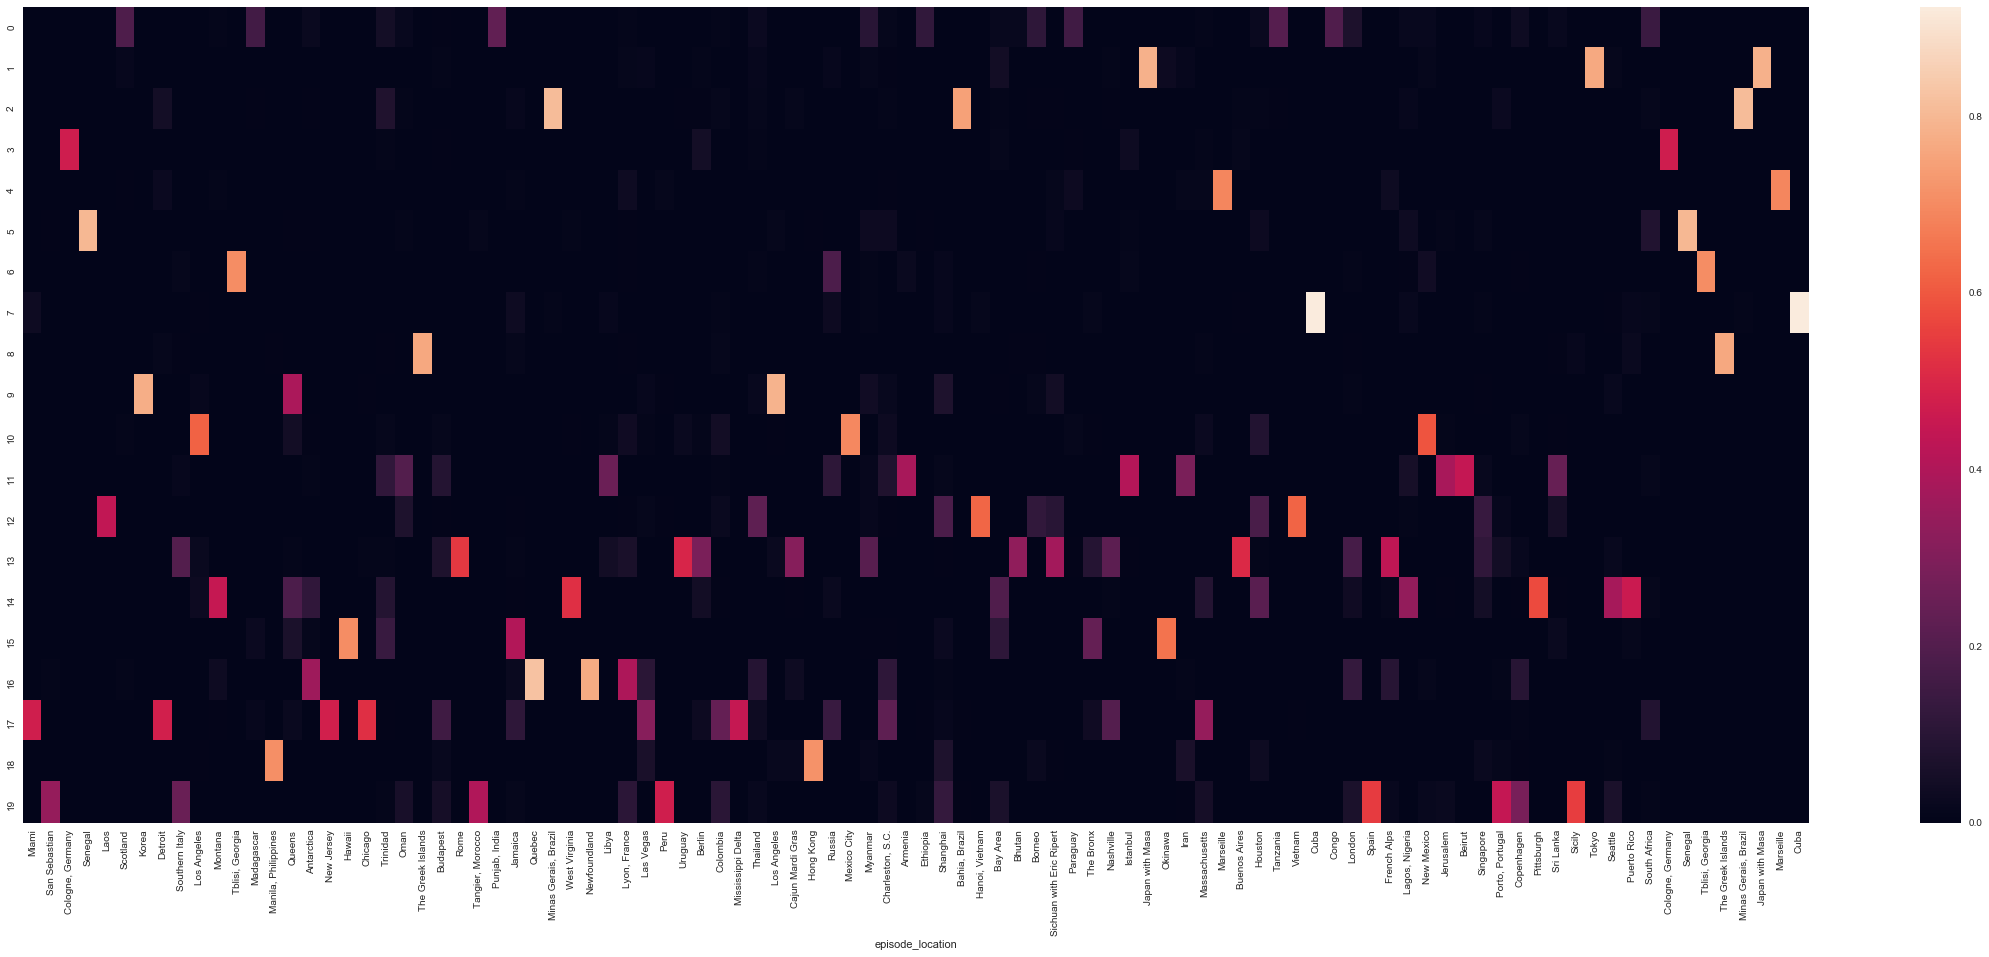

In [74]:
plt.subplots(figsize=(40,15))
sns.heatmap(episode_scores)
plt.show()

### K-means clustering; try later

clustering code from K2 lecture material to try later

In [ ]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens

def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering

In [ ]:
clusters = cluster_texts(articles, 7)
pprint(dict(clusters))